In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier

# from interpret import set_visualize_provider
# from interpret.provider import InlineProvider
# set_visualize_provider(InlineProvider())

In [2]:
# import data
df = pd.read_csv("./data/CEE_DATA.csv", quotechar="'")

X = df[
    [
        "Gender",
        "Caste",
        "coaching",
        "time",
        "Class_ten_education",
        "twelve_education",
        "medium",
        "Class_X_Percentage",
        "Class_XII_Percentage",
        "Father_occupation",
        "Mother_occupation",
    ]
]
Y = df["Performance"]

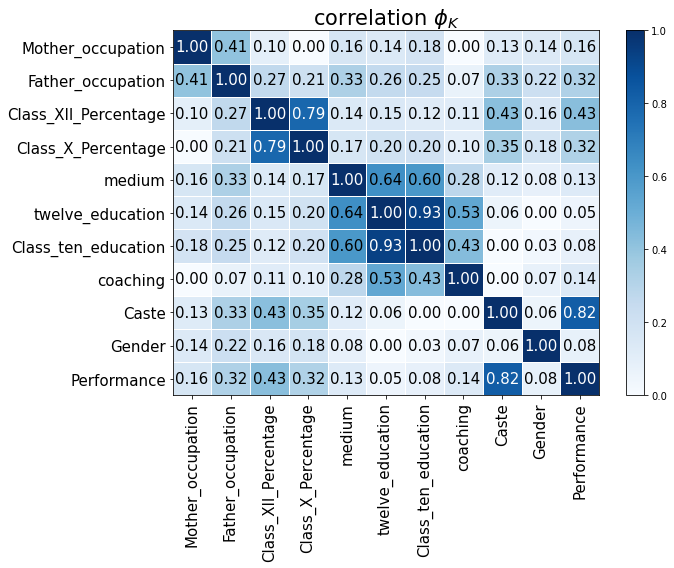

In [3]:
import phik
from phik.report import plot_correlation_matrix
%matplotlib inline

df_for_phik = df.drop(['time'], axis=1)
phik_overview = df_for_phik.phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()
plt.savefig('./docs/phi_k_correlations.png', bbox_inches='tight')
plt.show()

In [4]:
# split data
seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=seed
)
print("Train Size Instances: ", X_train.shape[0])
print("Test Size Instances:", X_test.shape[0])

Train Size Instances:  466
Test Size Instances: 200


In [5]:
ohe = OneHotEncoder(sparse=False)
Xoded = pd.DataFrame(ohe.fit_transform(X),columns=ohe.get_feature_names(['Gender', 'Caste', 'coaching', 'time', 'Class_ten_education',
       'twelve_education', 'medium', 'Class_X_Percentage',
       'Class_XII_Percentage', 'Father_occupation', 'Mother_occupation']))
X_train_enc, X_test_enc, Y_train_enc, Y_test_enc = train_test_split(
    Xoded, Y, test_size=0.3, random_state=seed
)
print("Train Size Instances: ", X_train_enc.shape[0])
print("Test Size Instances:", X_test_enc.shape[0])

Train Size Instances:  466
Test Size Instances: 200


## EBM

In [6]:
# https://interpret.ml/docs/ebm.html?highlight=multiclass#

ebm = ExplainableBoostingClassifier(random_state=seed)
ebm.fit(X_train, Y_train)

# global explanations
ebm_global = ebm.explain_global()
show(ebm_global)

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\glassbox\ebm\ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")
C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\glassbox\ebm\ebm.py:925: UserWarning: Detected multiclass problem: forcing interactions to 0
  warn("Detected multiclass problem: forcing interactions to 0")
C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Anaconda\anaconda3\envs\Rn

<!-- http://127.0.0.1:7001/1540192710560/ -->

In [7]:
ebm_global.data(-1)

{'overall': {'type': 'univariate',
  'names': ['Gender',
   'Caste',
   'coaching',
   'time',
   'Class_ten_education',
   'twelve_education',
   'medium',
   'Class_X_Percentage',
   'Class_XII_Percentage',
   'Father_occupation',
   'Mother_occupation'],
  'scores': [0.04646169877946545,
   0.7570752840339648,
   0.1302763748957357,
   0.14802091237685572,
   0.12133939822327415,
   0.1173290460826962,
   0.13723345201926537,
   0.11642691564352671,
   0.20385361664274151,
   0.11704536224347514,
   0.08136793428855146]},
 'specific': [{'type': 'univariate',
   'names': ['female', 'male'],
   'scores': array([[ 0.07586847, -0.08201851, -0.02397834,  0.0167691 ],
          [-0.06669083,  0.07209691,  0.02107774, -0.01474058]]),
   'scores_range': (-2.5931982149691297, 3.205159687899679),
   'upper_bounds': array([[ 0.11362153, -0.0595978 ,  0.01190111,  0.03910761],
          [-0.02685585,  0.08815176,  0.05128844,  0.00420558]]),
   'lower_bounds': array([[ 0.03811541, -0.10443921, 

In [8]:
ebm.get_params()

{'binning': 'quantile',
 'early_stopping_rounds': 50,
 'early_stopping_tolerance': 0.0001,
 'feature_names': ['Gender',
  'Caste',
  'coaching',
  'time',
  'Class_ten_education',
  'twelve_education',
  'medium',
  'Class_X_Percentage',
  'Class_XII_Percentage',
  'Father_occupation',
  'Mother_occupation'],
 'feature_types': ['categorical',
  'categorical',
  'categorical',
  'categorical',
  'categorical',
  'categorical',
  'categorical',
  'categorical',
  'categorical',
  'categorical',
  'categorical'],
 'inner_bags': 0,
 'interactions': 0,
 'learning_rate': 0.01,
 'mains': 'all',
 'max_bins': 256,
 'max_interaction_bins': 32,
 'max_leaves': 3,
 'max_rounds': 5000,
 'min_samples_leaf': 2,
 'n_jobs': -2,
 'outer_bags': 8,
 'random_state': 1,
 'validation_size': 0.15}

In [9]:
# local explanations
ebm_local = ebm.explain_local(X_test[:5], Y_train[:5])
show(ebm_local)

<!-- http://127.0.0.1:7001/1540213925536/ -->

Accuracy:  0.475
Precision:  0.47454150369404613
Recall:  0.4653538953823584
F1 score:  0.45145953532565164
              precision    recall  f1-score   support

     Average       0.68      0.77      0.72        44
   Excellent       0.38      0.16      0.23        31
        Good       0.47      0.38      0.42        74
          Vg       0.36      0.55      0.43        51

    accuracy                           0.48       200
   macro avg       0.47      0.47      0.45       200
weighted avg       0.48      0.47      0.46       200



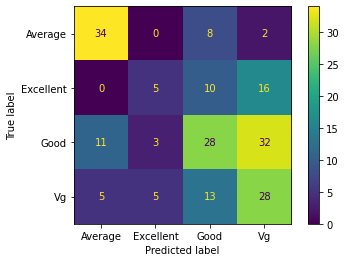

In [10]:
Y_pred = ebm.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(Y_test, Y_pred))
print("Precision: ", metrics.precision_score(Y_test, Y_pred, average="macro"))
print("Recall: ", metrics.recall_score(Y_test, Y_pred, average="macro"))
print("F1 score: ", metrics.f1_score(Y_test, Y_pred, average="macro"))
print(metrics.classification_report(Y_test, Y_pred, target_names=ebm.classes_))
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=ebm.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ebm.classes_)
disp.plot()
plt.show()

## Linear Model

In [11]:
# https://interpret.ml/docs/lr.html

from interpret.glassbox import LogisticRegression

lr = LogisticRegression(random_state=seed)
lr.fit(X_train_enc, Y_train_enc)

lr_global = lr.explain_global()
show(lr_global)

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



<!-- http://127.0.0.1:7001/1540130479840/ -->

In [12]:
# seems this one doesn't support strings for y labels
# lr_local = lr.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(lr_local)

In [13]:
def show_metrics(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    print("Accuracy: ", metrics.accuracy_score(Y_test, Y_pred))
    print("Precision: ", metrics.precision_score(Y_test, Y_pred, average="macro"))
    print("Recall: ", metrics.recall_score(Y_test, Y_pred, average="macro"))
    print("F1 score: ", metrics.f1_score(Y_test, Y_pred, average="macro"))
    print(metrics.classification_report(Y_test, Y_pred, target_names=model._model().classes_))
    cm = metrics.confusion_matrix(Y_test, Y_pred, labels=model._model().classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model._model().classes_)
    disp.plot()
    plt.show()

Accuracy:  0.49
Precision:  0.484970050441362
Recall:  0.48095502566565185
F1 score:  0.4683762666431013
              precision    recall  f1-score   support

     Average       0.67      0.80      0.73        44
   Excellent       0.40      0.19      0.26        31
        Good       0.49      0.41      0.44        74
          Vg       0.38      0.53      0.44        51

    accuracy                           0.49       200
   macro avg       0.48      0.48      0.47       200
weighted avg       0.49      0.49      0.48       200



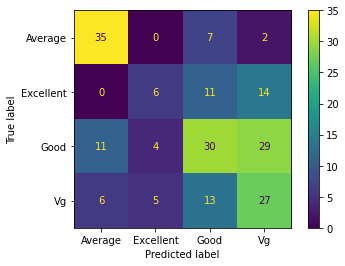

In [14]:
show_metrics(lr, X_test_enc, Y_test_enc)

## Decision tree

In [15]:
from interpret.glassbox import ClassificationTree

dt = ClassificationTree(random_state=seed)
dt.fit(X_train_enc, Y_train_enc)

dt_global = dt.explain_global()
show(dt_global)

<!-- http://127.0.0.1:7001/1540132295680/ -->

In [16]:
# seems this one doesn't support strings for y labels
# dt_local = dt.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(dt_local)

Accuracy:  0.415
Precision:  0.31522727272727274
Recall:  0.4523101029268012
F1 score:  0.35457516339869277
              precision    recall  f1-score   support

     Average       0.69      0.86      0.77        44
   Excellent       0.25      0.16      0.20        31
        Good       0.00      0.00      0.00        74
          Vg       0.32      0.78      0.45        51

    accuracy                           0.41       200
   macro avg       0.32      0.45      0.35       200
weighted avg       0.27      0.41      0.32       200



C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

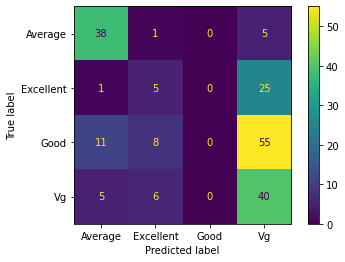

In [17]:
show_metrics(dt, X_test_enc, Y_test_enc)

## Descision Rule

In [18]:
from interpret.glassbox import DecisionListClassifier

dl = DecisionListClassifier(random_state=seed)
dl.fit(X_train_enc, Y_train_enc)

dl_global = dl.explain_global()
show(dl_global)

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\skrules\skope_rules.py:214: UserWarning:

Found labels {0, 1, 2, 3}. This method assumes target class to be labeled as 1 and normal data to be labeled as 0. Any label different from 0 will be considered as being from the target class.



<!-- http://127.0.0.1:7001/1540228944896/ -->

In [19]:
# seems this one doesn't support strings for y labels
# dl_local = dl.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(dl_local)

Accuracy:  0.155
Precision:  0.03875
Recall:  0.25
F1 score:  0.0670995670995671
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00        44
   Excellent       0.15      1.00      0.27        31
        Good       0.00      0.00      0.00        74
          Vg       0.00      0.00      0.00        51

    accuracy                           0.15       200
   macro avg       0.04      0.25      0.07       200
weighted avg       0.02      0.15      0.04       200



C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Anaconda\anaconda3\envs\RnD\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

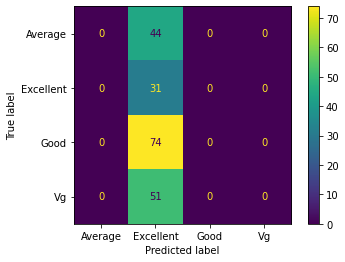

In [20]:
Y_pred = dl.predict(X_test_enc)
print("Accuracy: ", metrics.accuracy_score(Y_test, Y_pred))
print("Precision: ", metrics.precision_score(Y_test, Y_pred, average="macro"))
print("Recall: ", metrics.recall_score(Y_test, Y_pred, average="macro"))
print("F1 score: ", metrics.f1_score(Y_test, Y_pred, average="macro"))
print(metrics.classification_report(Y_test, Y_pred, target_names=dl.classes_))
cm = metrics.confusion_matrix(Y_test, Y_pred, labels=dl.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dl.classes_)
disp.plot()
plt.show()